# Sketch of Stream Plot comparisons

Sketch out drawing a panel of plots that show circulation climatology  patterns over the larger north west Europe region. Allowing comparison between reanalysis products, historical era simulation and future projections. 

*There are some advantages to doing this same analysis but with Geo-potential Height at different pressure levels over a still larger region. That would allow a better sense of the location of different synoptic features, and allow us to 'diff' the fields in a meaningful way.*

*Since this is just a demonstration will pretend that the fact that the quick grab ERA5-Reanalysis values are for the years 2008 through 2018 (in the plots call it the "Contemporary" period). So exactly in between the "historical" and "projection" period. This means that can't really make a direct comparison between the Reanalysis and the Historical climatology. On the other hand, maybe that's actually really interesting, since the three things we are looking at are "best guess to what things are like now", "simulation's idea of what 'normal' is like" and "simulation's interpretation of result of increasing emissions".*

In [1]:
## Libraries
import matplotlib.pyplot as plt             
import matplotlib as mp
import seaborn as sns
import xarray as xr
import pandas as pd
import numpy as np
import cartopy

from matplotlib import cm
from cartopy.io.img_tiles import Stamen
from cdo import *
cdo = Cdo()

%matplotlib inline 

## Map backgrounds 
stamen_terrain = Stamen('terrain-background') 
stamen_toner   = Stamen('toner-background')

month_labs = [
    'January','February', 'March','April',
    'May','June','July','August',
    'September','October','November','December']

In [2]:
min_lat =  50.0 #D.lat.values.min()
max_lat =  54.0 #D.lat.values.max()
min_lon =  -2.0 #D.lon.values.min()
max_lon =   6.0 #D.lon.values.max()
clon = min_lon + (max_lon - min_lon)/2.0
clat = min_lat + (max_lat - min_lat)/2.0 

In [3]:
path_sims = '../data'
sim_labs = [
    (path_sims+'/NorthSea_%s_EUR-11_NCC-NorESM1-M'
     + '_%s_r1i1p1_DMI-HIRHAM5_v2_day.nc')]

In [4]:
## Create list of simulations 

# file_list = grod.glob(path_sims+'/NorthSea_*uas*historical*.nc')
# sim_labs = []
# for f in file_list :
#     x = f.split('_')
#     x[1] = '%s'
#     x[4] = '%s'
#     sim_labs += [('_').join(x)]
#    

In [5]:
ix_sim = 0
u = xr.open_dataset(
    (sim_labs[ix_sim] % ('uas','historical'))
)['uas']
idx_clim = [x in range(1976,2006) for x in u.time.dt.year]
u_hist = u.sel(time=idx_clim)
uwnd_clim_hist = u_hist.groupby(u_hist.time.dt.month).mean('time')

ix_sim = 0
v = xr.open_dataset(
    (sim_labs[ix_sim] % ('vas','historical'))
)['vas']
idx_clim = [x in range(1976,2006) for x in v.time.dt.year]
v_hist = v.sel(time=idx_clim)
vwnd_clim_hist = v_hist.groupby(v_hist.time.dt.month).mean('time')

ws_clim_hist = uwnd_clim_hist.copy(deep=True)
ws_clim_hist.values = ((uwnd_clim_hist**2)+(vwnd_clim_hist**2))**0.5
ws_clim_hist = ws_clim_hist.rename('ws')

In [6]:
ix_sim = 0
u = xr.open_dataset(
    (sim_labs[ix_sim] % ('uas','rcp85'))
)['uas']
idx_clim = [x in range(2021,2051) for x in u.time.dt.year]
u_proj = u.sel(time=idx_clim)
uwnd_clim_proj = u_proj.groupby(u_proj.time.dt.month).mean('time')

ix_sim = 0
v = xr.open_dataset(
    (sim_labs[ix_sim] % ('vas','rcp85'))
)['vas']
idx_clim = [x in range(2021,2051) for x in v.time.dt.year]
v_proj = v.sel(time=idx_clim)
vwnd_clim_proj = v_proj.groupby(v_proj.time.dt.month).mean('time')

ws_clim_proj = uwnd_clim_proj.copy(deep=True)
ws_clim_proj.values = ((uwnd_clim_proj**2)+(vwnd_clim_proj**2))**0.5
ws_clim_proj = ws_clim_proj.rename('ws')

In [7]:
u = xr.open_dataset(
    '../data/eastward_wind_at_10_metres_monmean_era5.nc'
)['eastward_wind_at_10_metres']
uwnd_clim_conp = u.groupby(u.time0.dt.month).mean('time0')

v = xr.open_dataset(
    '../data/northward_wind_at_10_metres_monmean_era5.nc'
)['northward_wind_at_10_metres']
vwnd_clim_conp = v.groupby(v.time0.dt.month).mean('time0')

ws_clim_conp = uwnd_clim_conp.copy(deep=True)
ws_clim_conp.values = ((uwnd_clim_conp**2)+(vwnd_clim_conp**2))**0.5
ws_clim_conp = ws_clim_conp.rename('ws')

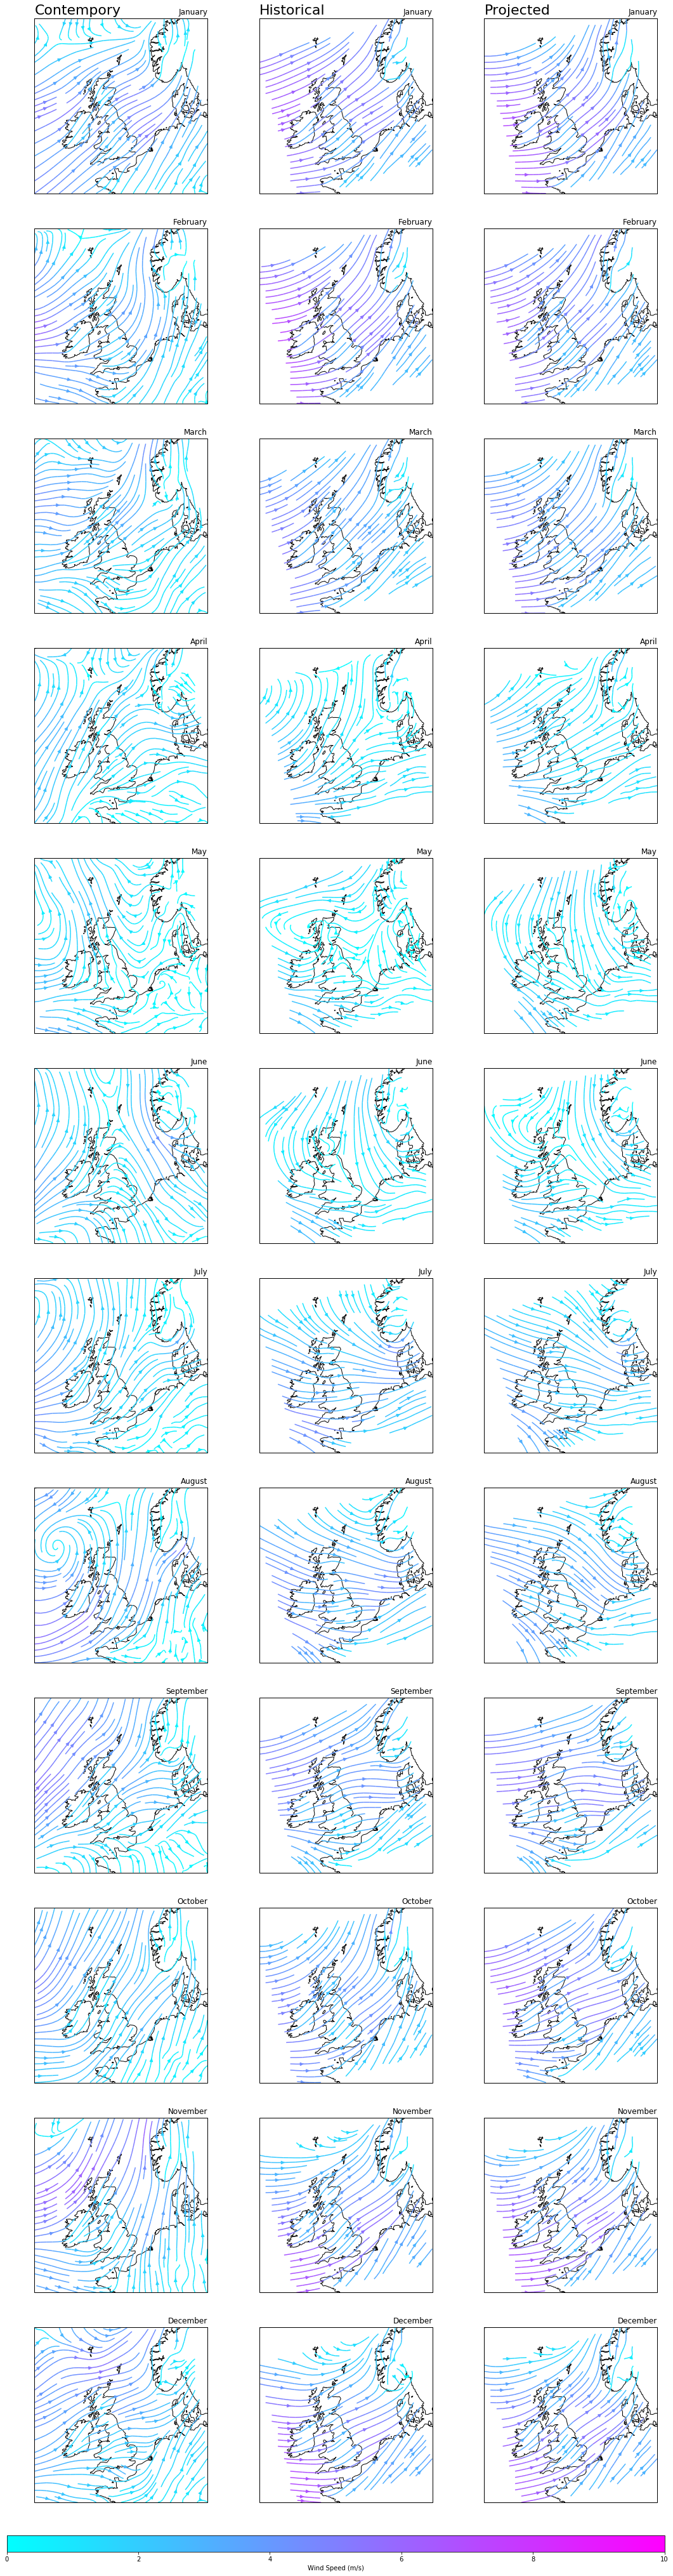

In [9]:
min_lat =  uwnd_clim_hist.lat.values.min()+0.5
max_lat =  uwnd_clim_hist.lat.values.max()-0.5
min_lon =  uwnd_clim_hist.lon.values.min()+5.0
max_lon =  uwnd_clim_hist.lon.values.max()-1.5
clon = min_lon + (max_lon - min_lon)/2.0
clat = min_lat + (max_lat - min_lat)/2.0 

fig = plt.figure(figsize=(3*6,12*6))
ix = 1
for month in range(12) : 

    chart = fig.add_subplot(
        12, 3, ix,
        projection=cartopy.crs.LambertConformal(
            central_longitude=clon,central_latitude=clat))
    _ = chart.set_extent(
        [min_lon, max_lon, min_lat, max_lat], 
        crs=cartopy.crs.PlateCarree())
    #_ = chart.add_image(stamen_terrain,5,interpolation='spline16')
    _ = chart.coastlines('50m')
    sp_hist = chart.streamplot(
        x=uwnd_clim_conp.lon.values,
        y=uwnd_clim_conp.lat.values,
        u=uwnd_clim_conp.values[month,:,:],
        v=vwnd_clim_conp.values[month,:,:],
        color=ws_clim_conp.values[month,:,:],
        cmap='cool',
        norm = cm.colors.Normalize(vmax=10, vmin=0),
        transform=cartopy.crs.PlateCarree())
    #_ = plt.colorbar(sp.lines)
    _ = chart.set_title(month_labs[month],loc='right')
    if ix == 1 :
        _ = chart.set_title(
            'Contempory',loc='left',
            fontdict={'fontsize' : 22 })
    ix += 1
        
    chart = fig.add_subplot(
        12, 3, ix,
        projection=cartopy.crs.LambertConformal(
            central_longitude=clon,central_latitude=clat))
    _ = chart.set_extent(
        [min_lon, max_lon, min_lat, max_lat], 
        crs=cartopy.crs.PlateCarree())
    #_ = chart.add_image(stamen_terrain,5,interpolation='spline16')
    _ = chart.coastlines('50m')
    sp_hist = chart.streamplot(
        x=uwnd_clim_hist.lon.values,
        y=uwnd_clim_hist.lat.values,
        u=uwnd_clim_hist.values[month,:,:],
        v=vwnd_clim_hist.values[month,:,:],
        color=ws_clim_hist.values[month,:,:],
        cmap='cool',
        norm = cm.colors.Normalize(vmax=10, vmin=0),
        transform=cartopy.crs.PlateCarree())
    #_ = plt.colorbar(sp.lines)
    _ = chart.set_title(month_labs[month],loc='right')
    if ix == 2 :
        _ = chart.set_title(
            'Historical',loc='left',
            fontdict={'fontsize' : 22 })
    ix += 1
    
    chart = fig.add_subplot(
        12, 3, ix,
        projection=cartopy.crs.LambertConformal(
            central_longitude=clon,central_latitude=clat))
    _ = chart.set_extent(
        [min_lon, max_lon, min_lat, max_lat], 
        crs=cartopy.crs.PlateCarree())
    _ = chart.coastlines('50m')
    sp_proj = chart.streamplot(
        x=uwnd_clim_proj.lon.values,
        y=uwnd_clim_proj.lat.values,
        u=uwnd_clim_proj.values[month,:,:],
        v=vwnd_clim_proj.values[month,:,:],
        color=ws_clim_proj.values[month,:,:],
        cmap='cool',
        norm = cm.colors.Normalize(vmax=10, vmin=0),
        transform=cartopy.crs.PlateCarree())
    _ = chart.set_title(month_labs[month],loc='right')
    if ix == 3 :
        _ = chart.set_title(
            'Projected',loc='left',
            fontdict={'fontsize' : 22 })
    ix += 1
        
_ = plt.colorbar(
    sp_hist.lines, 
    orientation='horizontal', 
    #cax = plt.axes([0.91, 0.05, 0.015, 0.9]),
    cax = plt.axes([0.1, 0.11, 0.8, 0.005]),
    label='Wind Speed (m/s)')
    
    